#Plotting and analyzing gatekeeper mutants for Src and Abl using bosutinib isomer data - w/ pymc delG estimates

We are plotting fluorescence assay spectra collected according to this lab-protocols protocol. Further details of the specific experiment can be found in the fluorescence assay lab notebook on December 15-18, 2015. This notebook is a deeper analysis of data from the 'Spectra-Assay-Analysis' notebook.

This notebook is meant to make a high quality figure showing the shift in bosutinib isomer affinity as a result of the gatekeeper mutant.

This notebook also includes pymc estimates for the deltaG of each bosutinib isomer to each protein.

In [1]:
import numpy as np
from lxml import etree
import pandas as pd
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

sns.set(style='white')
sns.set_context('talk')
%matplotlib inline

In [2]:
file_set = {'Src': glob("2015-12-15/*.xml"),
        'SrcGK': glob("2015-12-16/*.xml"),
        'AblGK': glob("2015-12-17/*.xml"),
        'Abl': glob("2015-12-18/*.xml")}

In [3]:
#Define ligands and ligand concentration
ligands = ['Bosutinib','Bosutinib Isomer','Erlotinib','Gefitinib']
ligand_conc = np.array([20.0e-6,9.15e-6,4.18e-6,1.91e-6,0.875e-6,0.4e-6,0.183e-6,0.0837e-6,0.0383e-6,0.0175e-6,0.008e-6,0.0001e-6], np.float64) # ligand concentration, M

In [4]:
ligand_conc

array([  2.00000000e-05,   9.15000000e-06,   4.18000000e-06,
         1.91000000e-06,   8.75000000e-07,   4.00000000e-07,
         1.83000000e-07,   8.37000000e-08,   3.83000000e-08,
         1.75000000e-08,   8.00000000e-09,   1.00000000e-10])

In [5]:
#This function allows us to import xml format data files and convert them to a pandas dataframe
def xml2df(file):

    root = etree.parse(file)

    data = []

    reads = root.xpath("/*/Section[1]/*/Well")

    wellIDs = [read.attrib['Pos'] for read in reads]

    data = [(s.text, float(s.attrib['WL']), r.attrib['Pos'])
        for r in reads
        for s in r]

    dataframe = pd.DataFrame(data, columns=['fluorescence','wavelength (nm)','Well'])
            
    ### dataframe_rep replaces 'OVER' (when fluorescence signal maxes out) with '3289277', an arbitrarily high number

    dataframe_rep = dataframe.replace({'OVER':'3289277'})

    dataframe_rep[['fluorescence']] = dataframe_rep[['fluorescence']].astype('float')
            
    dataframe_pivot = pd.pivot_table(dataframe_rep, index = 'wavelength (nm)', columns = ['Well'])
    
    #Rearrange columns so they're in the right order
    cols =  dataframe_pivot['fluorescence'].columns.tolist()
    cols = [cols[0]] + cols[4:12] + cols[1:4] + [cols[12]] + cols[16:24] + cols[13:16]
    dataframe_reindex =  dataframe_pivot.reindex_axis(cols,level='Well',axis=1)
    
    return dataframe_reindex

In [6]:
AblGK_BSI = xml2df(file_set['AblGK'][1])
AblGK_BSI_480 = AblGK_BSI.loc[480][:12]
BSI_480_GK = AblGK_BSI.loc[480][12:]

In [7]:
Abl_BSI = xml2df(file_set['Abl'][1])
Abl_BSI_480 = Abl_BSI.loc[480][:12]
BSI_480 = Abl_BSI.loc[480][12:]

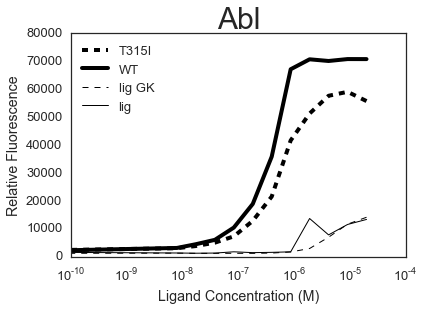

In [8]:
plt.semilogx(ligand_conc,AblGK_BSI_480.values,linewidth=4,color='k',linestyle='--',label='T315I')
plt.semilogx(ligand_conc,Abl_BSI_480.values,linewidth=4,color='k',label='WT')
plt.semilogx(ligand_conc,BSI_480_GK.values,linewidth=1,color='k',linestyle='--',label='lig GK')
plt.semilogx(ligand_conc,BSI_480.values,linewidth=1,color='k',label='lig')
plt.legend(loc=2)
plt.title('Abl',fontsize=30)
plt.xlabel('Ligand Concentration (M)')
plt.ylabel('Relative Fluorescence')

In [9]:
Abl_Complex_Fluorescence = Abl_BSI_480.values
AblGK_Complex_Fluorescence = AblGK_BSI_480.values
Abl_Ligand_Fluorescence = BSI_480_GK.values
AblGK_Ligand_Fluorescence = BSI_480.values

In [10]:
#Bosutinib Isomer concentration (M):
Lstated = ligand_conc
#Protein concentration (M):
Pstated = 1.0e-6 * np.ones([12],np.float64)

In [11]:
# Assay configuration details
import math
assay_volume = 100e-6 # assay volume, L
well_area = 0.3969 # well area, cm^2 for 4ti-0223 [http://4ti.co.uk/files/1614/0542/7662/4ti-0223_Marketing_Drawing.pdf]
path_length = assay_volume * 1000 / well_area # cm, needed for inner filter effect corrections     

# Uncertainties in protein and ligand concentrations.
dPstated = 0.35 * Pstated # protein concentration uncertainty
dLstated = 0.08 * Lstated # ligand concentraiton uncertainty (due to gravimetric preparation and HP D300 dispensing)

In [12]:
# Create the pymc model
from assaytools import pymcmodels
pymc_model = pymcmodels.make_model(Pstated, dPstated, Lstated, dLstated, 
               top_complex_fluorescence=Abl_Complex_Fluorescence,
               top_ligand_fluorescence=Abl_Ligand_Fluorescence,
               use_primary_inner_filter_correction=True, 
               use_secondary_inner_filter_correction=True, 
               assay_volume=assay_volume, well_area=well_area, DG_prior='uniform')
 

Couldn't import dot_parser, loading of dot files will not be possible.


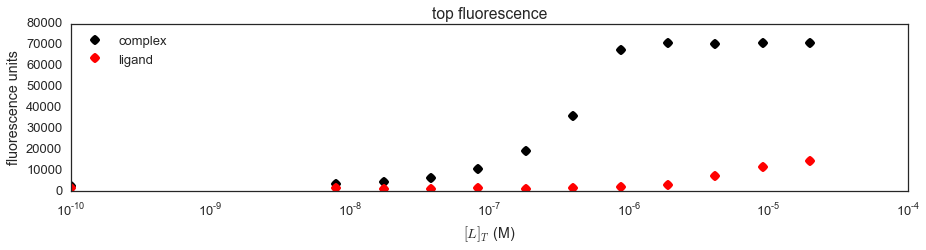

In [13]:
from assaytools import plots
figure = plots.plot_measurements(Lstated, Pstated, pymc_model)

In [14]:
# Find the maximum a posteriori fit (will only be local optimum, and several cycles are needed for reasonable fit)
map = pymcmodels.map_fit(pymc_model)

MAP fitting cycle 5/5


In [15]:
map.sigma_top.value

80.141118216330057

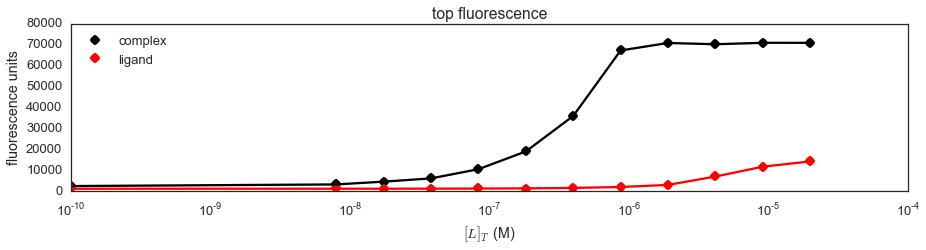

In [16]:
figure = plots.plot_measurements(Lstated, Pstated, pymc_model, map=map)


In [17]:
mcmc = pymcmodels.run_mcmc(pymc_model)

(1000,)


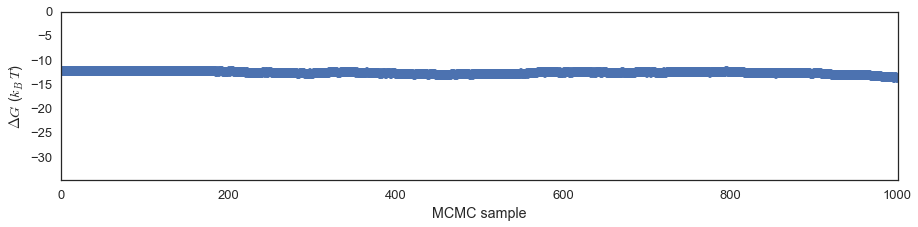

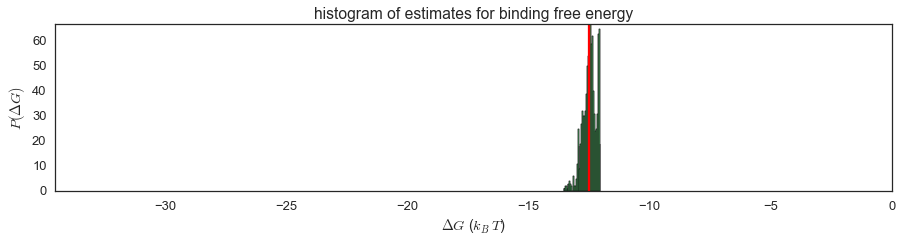

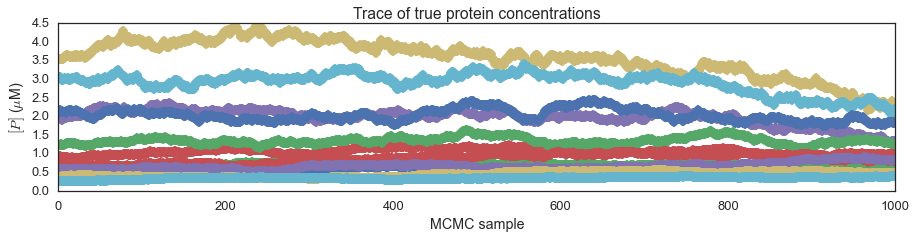

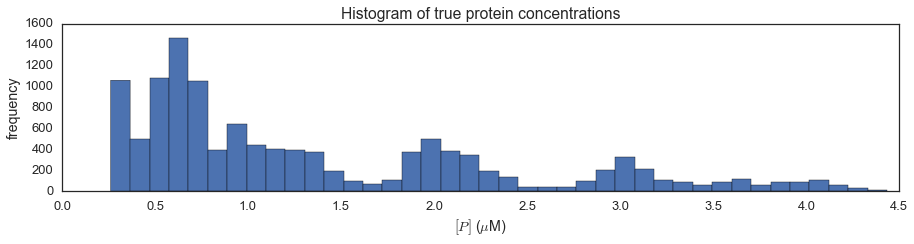

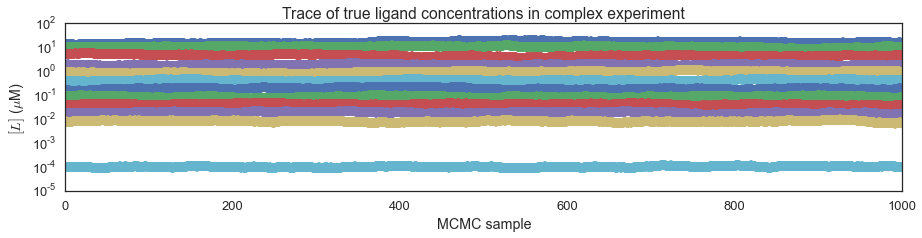

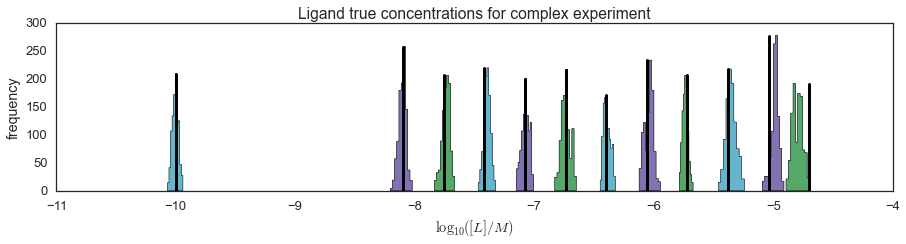

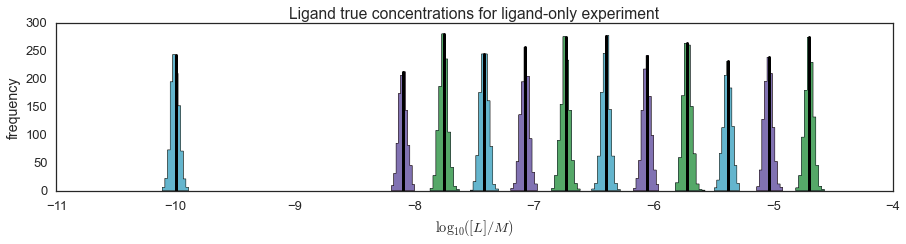

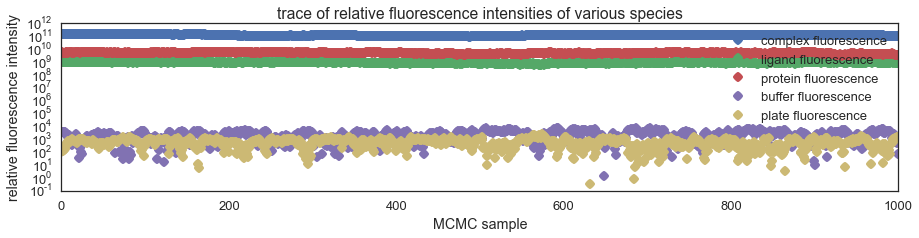

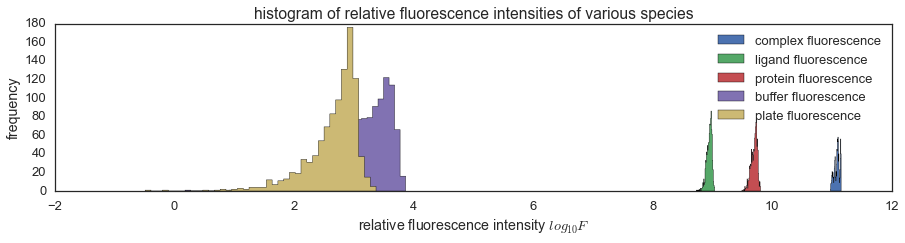

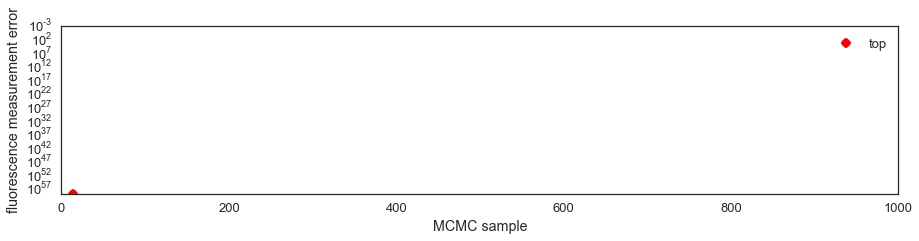

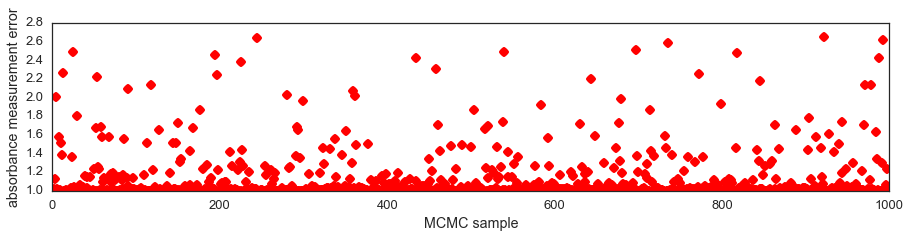

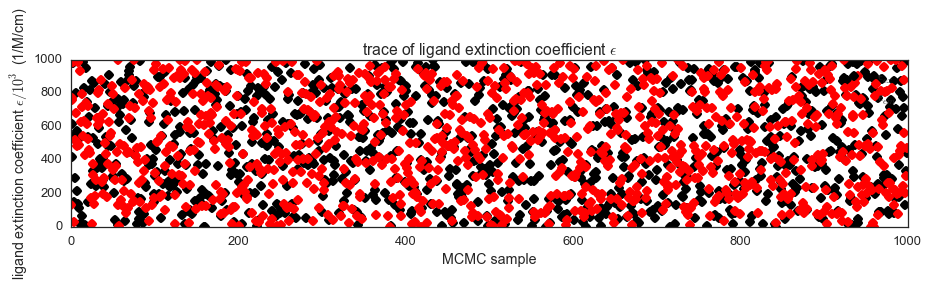

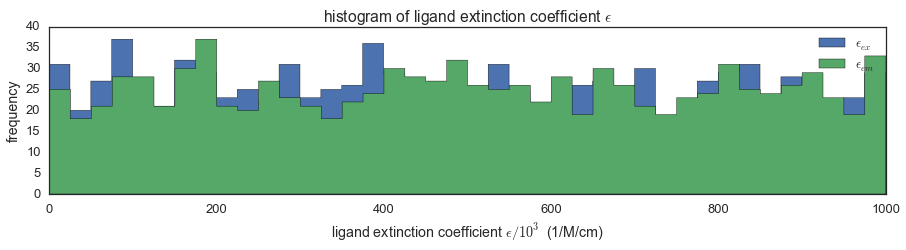

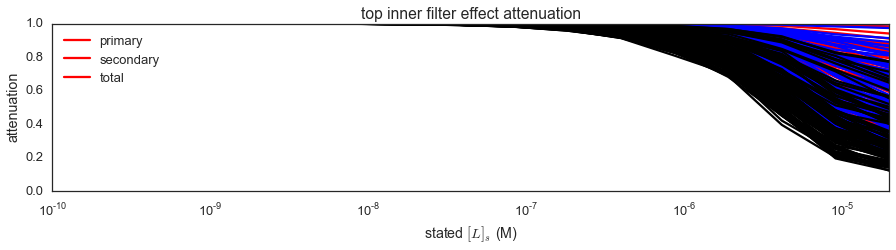

In [18]:
plots.plot_mcmc_results(Lstated, Pstated, path_length, mcmc)


In [19]:
mcmc = pymcmodels.run_mcmc(pymc_model)


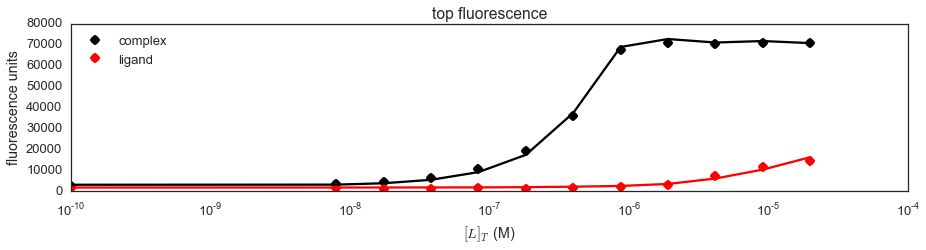

In [20]:
figure = plots.plot_measurements(Lstated, Pstated, pymc_model, map=map)


In [21]:
print "DeltaG = %.1f +- %.1f kT" % (map.DeltaG.value, mcmc.DeltaG.trace().std())


DeltaG = -25.4 +- 4.7 kT


In [22]:
Kd_calc = np.exp(mcmc.DeltaG.trace()).mean()
dKd_calc = np.exp(mcmc.DeltaG.trace()).std()
print "Kd = %.3f +- %.3f nM" % (Kd_calc/1e-9, dKd_calc/1e-9)

Kd = 0.839 +- 2.620 nM
